# MidiNet doubleデモ

- サンプルの生成
- サンプルのオーディオ化
- サンプルの可視化，読込，再生

In [1]:
import os, ipdb, pickle, numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import pretty_midi
from pypianoroll import Multitrack, Track
from utils import grid_plot, Timer, ppr_to_audio, get_model, on_chord_rate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
learning_dir = f"{base_dir}/learning"

## サンプルの生成に必要なコード
主に
- SampleGenerator: Generatorからbatch_normを抜いたもの
- SongGenerator: SampleGeneratorを使って最初の小節，コード進行，セクション情報から曲(Multitrack)を作成

In [3]:
class SelfAttention(nn.Module):
    """ Self Attention Layer """
    
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        
        # Self Attention の学習に使用する層を定義
        
        # pointwise convolutionによる特徴量変換，圧縮
        # Attention Mapに使われるxは3つあり，それぞれに対して適用
        # これが非常に大きなカーネルを設定するよりも高速になるらしい
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        
        # Attention Map 作成時の規格化用Softmax
        self.softmax = nn.Softmax(dim=-2)
        
        # Attention Mapにかける係数
        self.gamma = nn.Parameter(torch.zeros(1))
        
        
    def forward(self, x, get_map=False):
        
        # (B, C', W, H) -> (B, C', N)
        proj_query = self.query_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        
        # 転置 x^t
        proj_query = proj_query.permute(0, 2, 1)
        
        # 転置してない方の x
        proj_key = self.key_conv(x).view(x.shape[0], -1, x.shape[2] * x.shape[3]) # (B, C', N)
        
        # バッチごとに行列の掛け算 x^t x を行う
        S = torch.bmm(proj_query, proj_key)
        
        # 規格化と転置を行い，Attention Mapを作成
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)
        
        # xに対応する調整量 o を取得
        proj_value = self.value_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3]) # (B, C', N)
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        
        # x + gamma o　を返す
        o = o.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        out = x + self.gamma * o
        
        if get_map:
            return out, attention_map
        else:
            return out

In [4]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

class Generator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(Generator, self).__init__()
        self.bars = 2
        self.z_dim   = z_dim
        self.y_dim   = 48 * self.bars
        self.prev_ch = 16 * self.bars
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(self.gf_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h2      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h3      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(3,1), stride=(3,1))
        self.h4      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h5      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h6      = nn.ConvTranspose2d(pitch_range+self.prev_ch, 1, kernel_size=(1,pitch_range), stride=(1,1))
        
        self.h0_prev = nn.Conv2d(1, self.prev_ch, kernel_size=(1,pitch_range), stride=(1,1))
        self.h1_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h2_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h3_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(3,1), stride=(3,1))
        self.h4_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h5_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        
        self.sa2 = SelfAttention(pitch_range+self.prev_ch)
        self.sa4 = SelfAttention(pitch_range+self.prev_ch)

        self.linear1 = nn.Linear(self.z_dim + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y):
        
        batch_size = len(z)
        
        h0_prev = lrelu(self.h0_prev(prev_x))   # 72, 32, 96, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(self.h1_prev(h0_prev))  # 72, 32, 48, 1
        h2_prev = lrelu(self.h2_prev(h1_prev))  # 72, 32, 24, 1
        h3_prev = lrelu(self.h3_prev(h2_prev))  # 72, 32, 8, 1
        h4_prev = lrelu(self.h4_prev(h3_prev))  # 72, 32, 4, 1
        h5_prev = lrelu(self.h5_prev(h4_prev))  # 72, 32, 2, 1

        z = torch.cat((z,y),1)                          # 72, 196

        h0 = F.relu(self.linear1(z))                    # 72, 1024
        h1 = F.relu(self.linear2(h0))                   # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)     # 72, 128, 2, 1
        
        h1 = concat_vector(h1, h5_prev)                 # 72, 160, 2, 1

        h2 = F.relu(self.h1(h1))                        # 72, 64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, h4_prev)                 # 72, 96, 4, 1
        h2 = self.sa2(h2)

        h3 = F.relu(self.h2(h2))                        # 72, 64, 8, 1 
        h3 = concat_vector(h3, h3_prev)                 # 72, 96, 8, 1

        h4 = F.relu(self.h3(h3))                        # 72, 64, 24, 1
        h4 = concat_vector(h4, h2_prev)                 # 72, 96, 24, 1
        h4 = self.sa4(h4)
        
        h5 = F.relu(self.h4(h4))                        # 72, 64, 48, 1
        h5 = concat_vector(h5, h1_prev)                 # 72, 96, 48, 1
        
        h6 = F.relu(self.h5(h5))                        # 72, 64, 96, 1
        h6 = concat_vector(h6, h0_prev)                 # 72, 96, 96, 1

        g_x = torch.sigmoid(self.h6(h6))                # 72, 1, 96, 64  ピッチ方向の逆畳み込み

        return g_x

SAの実装

In [5]:
# from torchgan SelfAttention2d
class SelfAttention(nn.Module):
    def __init__(self, input_dims, return_attn=False):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(input_dims, input_dims//8, 1)
        self.key = nn.Conv2d(input_dims, input_dims//8, 1)
        self.value = nn.Conv2d(input_dims, input_dims, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, get_map=False):
        dims = (x.size(0), -1, x.size(2) * x.size(3))
        out_query = self.query(x).view(dims)
        out_key = self.key(x).view(dims).permute(0, 2, 1)
        attn = F.softmax(torch.bmm(out_key, out_query), dim=-1)
        out_value = self.value(x).view(dims)
        out_value = torch.bmm(out_value, attn).view(x.size())
        out = self.gamma * out_value + x
        if get_map:
            return out, attn
        return out


SAを使うGenerator

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(Generator, self).__init__()
        self.bars = 4
        self.z_dim   = z_dim
        self.y_dim   = 48 * self.bars
        self.prev_ch = 8  * self.bars
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(self.gf_dim+self.y_dim+z_dim, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h2      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h3      = nn.ConvTranspose2d(pitch_range+self.y_dim+z_dim, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h4      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(3,1), stride=(3,1))
        self.h5      = nn.ConvTranspose2d(pitch_range, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h6      = nn.ConvTranspose2d(pitch_range+self.y_dim+z_dim, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h7      = nn.ConvTranspose2d(pitch_range+self.prev_ch, 1, kernel_size=(1,pitch_range), stride=(1,1))
        
        self.h0_prev = nn.Conv2d(1, self.prev_ch, kernel_size=(1,pitch_range), stride=(1,1))
        self.h1_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(12,1), stride=(12,1))
        self.h2_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(4,1), stride=(4,1))
        
        self.sa2 = SelfAttention(pitch_range+self.prev_ch)
        self.sa4 = SelfAttention(pitch_range+self.prev_ch)
        self.sa7 = SelfAttention(pitch_range+self.prev_ch)

        self.linear1 = nn.Linear(self.z_dim + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y, get_map=False):
        maps = []
        batch_size = len(z)
        
        h0_prev = lrelu(self.h0_prev(prev_x))   # 72, 32, 192, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(self.h1_prev(h0_prev))  # 72, 32,  16, 1
        h2_prev = lrelu(self.h2_prev(h1_prev))  # 72, 32,   4, 1

        z = torch.cat((z,y),1)                          # 72, 292
        yz = z.view(batch_size, self.y_dim+self.z_dim, 1, 1) # 72, 292,  1,  1

        h0 = F.relu(self.linear1(z))                    # 72, 1024
        h1 = F.relu(self.linear2(h0))                   # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)     # 72, 128,  2, 1
        
        h1 = concat_vector(h1, yz)                      # 72, 420,  2, 1

        h2 = F.relu(self.h1(h1))                        # 72, 64,   4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, h2_prev)                 # 72, 96,   4, 1
        
        if get_map:
            h2, h2_map = self.sa2(h2, get_map=get_map)
            maps.append(h2_map.detach().numpy())
        else:
            h2 = self.sa2(h2)
        
        h3 = F.relu(self.h2(h2))                        # 72, 64,   8, 1 
        h3 = concat_vector(h3, yz)                      # 72, 358,  8, 1

        h4 = F.relu(self.h3(h3))                        # 72, 64,  16, 1
        h4 = concat_vector(h4, h1_prev)                 # 72, 96,  16, 1
        
        if get_map:
            h4, h4_map = self.sa4(h4, get_map=get_map)
            maps.append(h4_map.detach().numpy())
        else:
            h4 = self.sa4(h4)
        
        h5 = F.relu(self.h4(h4))                        # 72, 64,  48, 1
        h6 = F.relu(self.h5(h5))                        # 72, 64,  96, 1
        h6 = concat_vector(h6, yz)                      # 72, 358, 96, 1

        h7 = F.relu(self.h6(h6))                        # 72, 64, 192, 1
        h7 = concat_vector(h7, h0_prev)                 # 72, 96, 192, 1
        
        if get_map:
            h7, h7_map = self.sa7(h7, get_map=get_map)
            maps.append(h7_map.detach().numpy())
        else:
            h7 = self.sa7(h7)
        
        g_x = torch.sigmoid(self.h7(h7))                # 72, 1,  192, 64  ピッチ方向の逆畳み込み

        if get_map:
            return g_x, maps
        else:
            return g_x

SAを使わないGenerator

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(Generator, self).__init__()
        self.bars = 4
        self.z_dim   = z_dim
        self.y_dim   = 48 * self.bars
        self.prev_ch = 8  * self.bars
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(self.gf_dim+self.y_dim+z_dim, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h2      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h3      = nn.ConvTranspose2d(pitch_range+self.y_dim+z_dim, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h4      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(3,1), stride=(3,1))
        self.h5      = nn.ConvTranspose2d(pitch_range, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h6      = nn.ConvTranspose2d(pitch_range+self.y_dim+z_dim, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h7      = nn.ConvTranspose2d(pitch_range+self.prev_ch, 1, kernel_size=(1,pitch_range), stride=(1,1))
        
        self.h0_prev = nn.Conv2d(1, self.prev_ch, kernel_size=(1,pitch_range), stride=(1,1))
        self.h1_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(12,1), stride=(12,1))
        self.h2_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(4,1), stride=(4,1))

        self.linear1 = nn.Linear(self.z_dim + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y):
        
        batch_size = len(z)
        
        h0_prev = lrelu(self.h0_prev(prev_x))   # 72, 32, 192, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(self.h1_prev(h0_prev))  # 72, 32,  16, 1
        h2_prev = lrelu(self.h2_prev(h1_prev))  # 72, 32,   4, 1

        # yb = y.view(batch_size, self.y_dim, 1, 1)       
        z = torch.cat((z,y),1)                          # 72, 292
        yz = z.view(batch_size, self.y_dim+self.z_dim, 1, 1) # 72, 292,  1,  1

        h0 = F.relu(self.linear1(z))                    # 72, 1024
        h1 = F.relu(self.linear2(h0))                   # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)     # 72, 128,  2, 1
        
        h1 = concat_vector(h1, yz)                      # 72, 420,  2, 1

        h2 = F.relu(self.h1(h1))                        # 72, 64,   4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, h2_prev)                 # 72, 96,   4, 1
        
        h3 = F.relu(self.h2(h2))                        # 72, 64,   8, 1 
        h3 = concat_vector(h3, yz)                      # 72, 358,  8, 1

        h4 = F.relu(self.h3(h3))                        # 72, 64,  16, 1
        h4 = concat_vector(h4, h1_prev)                 # 72, 96,  16, 1
        
        h5 = F.relu(self.h4(h4))                        # 72, 64,  48, 1
        h6 = F.relu(self.h5(h5))                        # 72, 64,  96, 1
        h6 = concat_vector(h6, yz)                      # 72, 358, 96, 1

        h7 = F.relu(self.h6(h6))                        # 72, 64, 192, 1
        h7 = concat_vector(h7, h0_prev)                 # 72, 96, 192, 1
        
        g_x = torch.sigmoid(self.h7(h7))                # 72, 1,  192, 64  ピッチ方向の逆畳み込み

        return g_x

In [7]:
chord_key_dict = {
    'C'  : 0,
    'C#' : 1,
    'Db' : 1,
    'D'  : 2,
    'D#' : 3,
    'Eb' : 3,
    'E'  : 4,
    'F'  : 5,
    'F#' : 6,
    'Gb' : 6,
    'G'  : 7,
    'Ab' : 8,
    'A'  : 9,
    'A#' : 10,
    'Bb' : 10,
    'B'  : 11,
}

chord_kind_dict = {
    ''     : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    '5'    : [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'm'    : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    '7'    : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'M7'   : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'm7'   : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    'mM7'  : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    'sus4' : [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    '7sus4': [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
    'dim'  : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    'm7-5' : [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    'aug'  : [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    'add9' : [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    '6'    : [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
    'm6'   : [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
}

def get_chord_vector(chord_name, octave_range=1):
    chord_vector = [0] * 12 * octave_range
    if '#' in chord_name or 'b' in chord_name:
        key, kind = chord_name[:2], chord_name[2:]
    elif chord_name:
        key, kind = chord_name[:1], chord_name[1:]
    else:
        return chord_vector
    key, chord_vector[:12] = chord_key_dict[key], chord_kind_dict[kind]
    chord_vector = chord_vector[-key:] + chord_vector[:-key]
    return chord_vector
    

class SongIsNotGeneratedError(Exception):
    pass

class SongGenerator():
    def __init__(self, model):
        if not isinstance(model, Generator):
            raise ValueError("model type should be Generator.")
        
        self.model = model
        self.song_map = None

        self.bars = 4
        self.beat_res = 12
        self.beats_in_bar = 4
        self.bar_res = self.beats_in_bar * self.beat_res
        self.bars_step_num = self.bars * self.bar_res

        self.pitch_range = [36, 99]
        self.on_note_thresh = 0
        self.melody_is_monophonic = True
        self.fill_interval = None
        self.shortest_note_steps = None
        self.transpose = 0
    
    def make_vectors_from_chord_list(self, chord_list):
        # 拍ごとにコードベクトルへ変換
        chord_vectors = []
        for chord, beats in chord_list:
            chord_vector = get_chord_vector(chord)
            for b in range(beats):
                chord_vectors.append(chord_vector)
        
        # 最後の小節に空白があるならNo Chordで埋める
        overhang_beat_num = len(chord_vectors) % self.beats_in_bar
        if overhang_beat_num > 0:
            filling = get_chord_vector('')
            for i in range(self.beats_in_bar - overhang_beat_num):
                chord_vectors.append(filling)
        
        # 小節ごとのコードベクトルへ変換
        chord_vectors = np.array(chord_vectors)
        bars_num = int(np.ceil(len(chord_vectors) / (self.beats_in_bar * self.bars)))
        vector_len = 12 * self.beats_in_bar * self.bars
        chord_vectors = chord_vectors.reshape(bars_num, vector_len)
        
        return chord_vectors
        
    def make_pianoroll_from_chord_list(self, chord_list, octave=3):
        chord_vectors = []
        empty_vector = [0] * 12 * 2
        
        for chord, beats in chord_list:
            chord_vector = get_chord_vector(chord, octave_range=2)
            
            # コードの終端ステップは空にする
            for step in range(beats * self.beat_res - 1):
                chord_vectors.append(chord_vector)
            chord_vectors.append(empty_vector)
        
        # 最後の小節に空白があるならNo Chordで埋める
        overhang_step_num = len(chord_vectors) % (self.bar_res)
        if overhang_step_num > 0:
            for step in range(self.bar_res - overhang_step_num):
                chord_vectors.append(empty_vector)
        
        pianoroll = np.zeros([len(chord_vectors), 128])
        bottom, top = (octave+1) * 12, (octave + 3) * 12
        pianoroll[:, bottom:top] = chord_vectors
        
        return pianoroll

    def make_pianoroll_from_note_list(self, note_list):
        eye = np.eye(128)
        empty_vector = [0] * 128
        note_vectors = []
        
        for pitch, div in note_list:
            note_length = int(self.bar_res // div)
            
            if pitch is not None:
                note_vector = eye[pitch]
            else:
                note_vector = empty_vector
            
            if note_length > 1:
                # 長さが1ステップ分より長ければ，終端を空白にする
                for l in range(note_length - 1):
                    note_vectors.append(note_vector)
                note_vectors.append(empty_vector)
            else:
                note_vectors.append(note_vector)
        
        # 最後の小節に空白があるなら空白で埋める
        overhang_step_num = len(note_vectors) % (self.bar_res)
        if overhang_step_num > 0:
            for step in range(self.bar_res - overhang_step_num):
                note_vectors.append(empty_vector)
        
        pianoroll = np.array(note_vectors)
        
        return pianoroll
    
    def make_generated_bars_list_by_empty_bars(self, melody):
        empty_bars = []
        
        for bar in range(bars_num):
            left, right = bar*bar_res, (bar+1)*bar_res
            if not np.any(np.any(melody[left:right], axis=-1), axis=-1):
                empty_bars.append(bar)

        generated_bars_list = empty_bars
        
        return generated_bars_list
        
    def generate_melody(self, base_pianoroll, condition_vectors, generated_bars_list=None, get_map=False):
        bars_step_num = self.bars_step_num
        bottom, top = self.pitch_range
        bars_num = len(condition_vectors)
        
        maps_list = []
        
        # 必要小節分のノイズベクトルを一度に生成
        noise_vectors = torch.randn(bars_num, self.model.z_dim)
        
        # 必要小節分の空データを用意し，base melodyを仕込む.
        # base_melodyのcondition_vectorsの長さを超える部分はカット
        melody = torch.zeros([bars_step_num * bars_num, 128])
        base_melody = torch.from_numpy(base_pianoroll[:bars_num*bars_step_num].astype(np.float32))
        melody[:len(base_melody)] = base_melody
        
        condition_vectors = torch.from_numpy(condition_vectors.astype(np.float32))
        
        # 生成する小節の範囲が与えられていなければ，全ての空白の小節でメロディを作成する
        if generated_bars_list is None:
            generated_bars_list = self.make_generated_bars_list_by_empty_bars(melody)
        
        # 指定小節のメロディを各個生成
        for bars in generated_bars_list:
            noise_vector = noise_vectors[bars].view(1, -1)
            
            if bars == 0:
                # 最初の小節が無ければ空の小節を使用
                prev = torch.zeros([1, 1, bars_step_num, 128])
            else:
                # 最初でなければ前の小節を使用
                left, right = (bars-1) * bars_step_num, bars * bars_step_num
                prev = melody[left:right, bottom:top+1].view(1, 1, bars_step_num, 64)
            
            condition_vector = condition_vectors[bars].view(1, -1)
            
            if get_map:
                generated_bar, maps = self.model(noise_vector, prev, condition_vector, get_map=get_map)
                maps_list.append(maps)
            else:
                generated_bar = self.model(noise_vector, prev, condition_vector)
            
            left, right = bars * bars_step_num, (bars+1) * bars_step_num
            melody[left:right, bottom:top+1] = generated_bar[0][0]
        
        melody = melody.detach().numpy()
        
        # 生成されたデータを直接見るため，song_mapとして保持
        self.song_map = melody.copy()
        
        if get_map:
            return melody, maps_list
        else:
            return melody
    
    def monophonize(self, pianoroll):
        max_pitches = np.argmax(pianoroll, axis=1)
        empty_steps = np.where(np.any(pianoroll, axis=1) == False)[0]

        monophonic = np.zeros_like(pianoroll)
        monophonic[range(len(max_pitches)), max_pitches] = 1
        monophonic[empty_steps] = 0
                        
        return monophonic
    
    def fill(self, pianoroll):
        fill_int = self.fill_interval
        filled_len = len(pianoroll) // fill_int
        
        for filled_step in range(filled_len):
            left, right = filled_step * fill_int, (filled_step+1) * fill_int
            
            # filled_step区間内に存在するピッチ中，最頻のもので埋める
            steps, pitches = np.where(pianoroll[left:right])
            is_end_of_note = not np.any(pianoroll[right-1])
            if pitches.any():
                representative = np.argmax(np.bincount(pitches))
                pianoroll[steps+left, pitches] = 0
                pianoroll[left:right, representative] = 1
                
                # ステップの終端が空白なら音符の切れ目と判定してそこだけ切る
                if is_end_of_note:
                    pianoroll[right-1] = 0
                
        return pianoroll
    
    def remove_short_notes(self, melody):
        thresh = self.shortest_note_steps
        note_existence = np.any(melody, axis=1)
        
        last_pitches = None
        same_pitch_steps = 0
        for step, pitches in enumerate(melody):
            
            # 今のステップに音符があるなら，
            if note_existence[step]:
                # そこが音符の開始地点の時，新たな音符を開始
                if last_pitches is None:
                    last_pitches = pitches # 開始地点として保持し，
                    same_pitch_steps += 1  # 長さのカウントを開始
                # 前のステップから連続して同じ音符があるとき
                else:
                    # 同じ音程なら，その音符の長さのカウントアップ
                    if np.all(pitches == last_pitches):
                        same_pitch_steps += 1
                    # 異なる音程なら
                    else:
                        # その音符の長さが短い時には音符を削除し，
                        if same_pitch_steps < thresh:
                            melody[step - same_pitch_steps:step] = 0
                        # 新たな音符を開始
                        last_pitches = pitches
                        same_pitch_steps = 1
            
            # 今のステップが空白なら
            else:
                # ここまで空白が連続していないとき，
                if same_pitch_steps > 0:
                    # 前の音符が短い時にはその音符を削除
                    if same_pitch_steps < thresh:
                        melody[step - same_pitch_steps:step] = 0
                    # 空白を開始
                    last_pitches = None
                    same_pitch_steps = 0
        
        # 最後に短い音符があるとき，削除
        if same_pitch_steps == 1:
            melody[-1] = 0
        
        return melody
    
    def post_process_melody(self, melody):
        # 出力値が小さいところは休符の可能性が高いので消去
        melody[melody < self.on_note_thresh] = 0
        
        # 1ステップに1つの音が鳴るようにステップごとの最大値を取る
        if self.melody_is_monophonic:
            melody = self.monophonize(melody)
        
        if self.shortest_note_steps is not None:
            melody = self.remove_short_notes(melody)
        
        # 細かい音符を消し去るため，長さfill_resの区間ごとに使用率の最も高い音符で埋める
        if self.fill_interval is not None:
            melody = self.fill(melody)
        
        return melody

    def make_song(self, tracks, track_names, name=None):
        tracks = [Track(item, name=name) for item, name in zip(tracks, track_names)]
        
        downbeat = np.zeros(len(tracks[0].pianoroll), dtype=bool)
        downbeat[::self.bar_res] = True
        
        song = Multitrack(tracks=tracks, beat_resolution=self.beat_res, downbeat=downbeat)
        
        song.binarize()
        
        if self.transpose is not None:
            for track in song.tracks:
                track.transpose(self.transpose)
                
        if name is not None:
            song.name = name
        
        return song

    def generate(self, base_note_list, chord_list, generated_bars_list=None, name=None, get_map=False):
        base_pianoroll    = self.make_pianoroll_from_note_list(base_note_list)
        chord_vectors     = self.make_vectors_from_chord_list(chord_list)
        
        if get_map:
            melody_pianoroll, maps_list = self.generate_melody(base_pianoroll, chord_vectors, generated_bars_list, get_map)
        else:
            melody_pianoroll = self.generate_melody(base_pianoroll, chord_vectors, generated_bars_list, get_map)
        
        melody_pianoroll  = self.post_process_melody(melody_pianoroll)
        chord_pianoroll   = self.make_pianoroll_from_chord_list(chord_list)
        song              = self.make_song([melody_pianoroll, chord_pianoroll], ['melody', 'chord'], name)
        
        if get_map:
            return song, maps_list
        else:
            return song

    def show_map(self, figsize=(21, 7)):
        if self.song_map is None:
            raise SongIsNotGeneratedError("Generate song before show the result map of the generator.")
        bottom, top = self.pitch_range
        fig, ax = plt.subplots(figsize=figsize)
        return ax.imshow(np.flipud(self.song_map[:, bottom:top+1].T))

## 楽譜の生成
ここでRun All Aboveして以下で曲を作成する  
1. modelを選ぶ
2. sections, chords, primingを作る
3. SongGenerator(model).generate()で自動生成されたMultitrackオブジェクトを取得
4. 気に入ったらオーディオとして保存
5. また聞きたくなったらget_sample(search_dir)でAudioオブジェクトとMultitrackオブジェクトを得られる

In [48]:
version = "midinet_long_sa"
model = get_model(os.path.join(learning_dir, version), Generator, prefix="G_epoch")
song_generator = SongGenerator(model)

6 models found in ../datasets/theorytab/midinet/learning/midinet_long_sa
0: G_epoch=0050_z=256.pth
1: G_epoch=0100_z=256.pth
2: G_epoch=0150_z=256.pth
3: G_epoch=0200_z=256.pth
4: G_epoch=0250_z=256.pth
5: G_epoch=0300_z=256.pth
input the number of model:4
model is loaded from G_epoch=0250_z=256.pth


on chord rate 0.6331994645247657


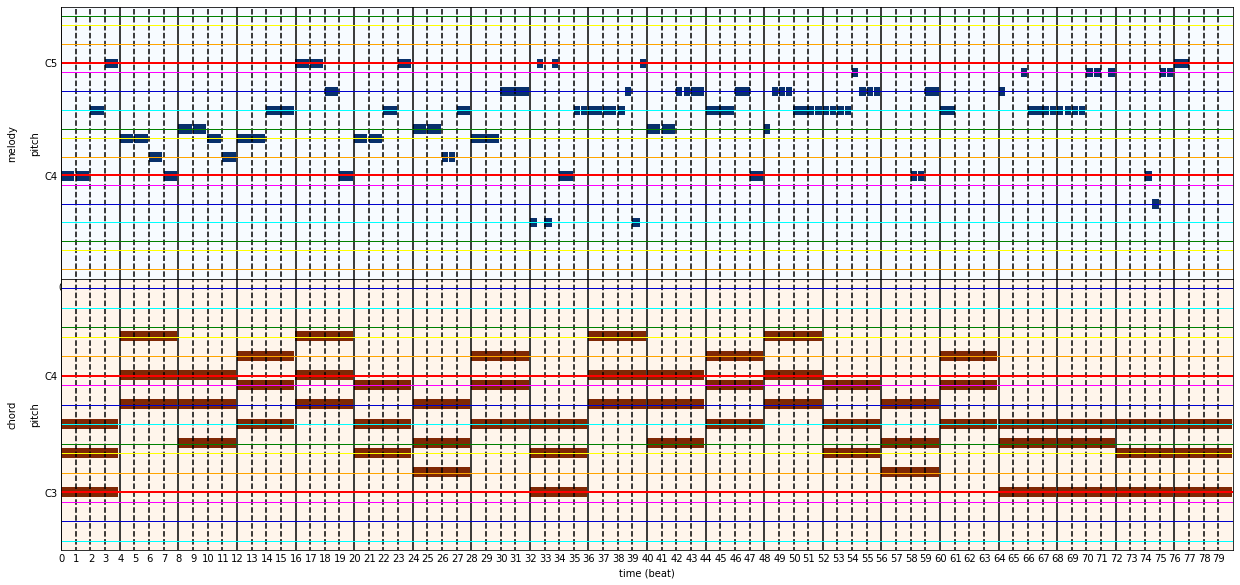

In [99]:
song_name = "sample000_C"

# コード進行，長さの単位は拍数
chords = [("C", 4), ("Am", 4), ("F", 4), ("G", 4), ("Am", 4), ("Em", 4), ("Dm", 4), ("G", 4),
          ("C", 4), ("Am", 4), ("F", 4), ("G", 4), ("Am", 4), ("Em", 4), ("Dm", 4), ("G", 4), 
          ("Csus4", 4), ("Csus4", 4), ("C", 4), ("C", 4)]

# ベースとなるメロディ，長さの単位は何分音符か．音符の終端は12分音符分カットされる
base = [(60, 4), (60, 4), (67, 4), (72, 4), (64, 4), (64, 4), (62, 4), (60, 4), 
        (65, 4), (65, 4), (64, 4), (62, 4), (64, 2), (67, 2), (None, 1/16)]

# 自動生成する小節の範囲
generated = list(range(1,5))

song_generator.on_note_thresh = 0.5
song_generator.fill_interval = 6
song, maps_list = song_generator.generate(base, chords, generated_bars_list=generated, name=song_name, get_map=True)
print("on chord rate", on_chord_rate(song))
grid_plot(song)

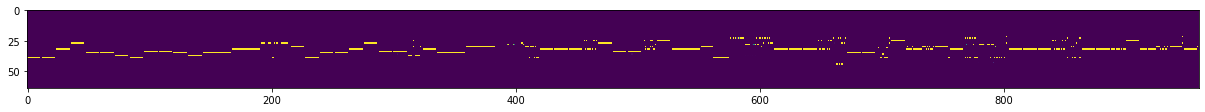

In [96]:
song_generator.show_map()

SelfAttentionの出力を確認

In [103]:
def show_attention_maps(maps_list):
    block_num = len(maps_list)
    maps_num = len(maps_list[0])
    
    fig, axs = plt.subplots(block_num, maps_num, figsize=(15, 20))
    
    for i in range(block_num):
        for j in range(maps_num):
            axs[i][j].set_title(f"block{i}-map{j}")
            axs[i][j].set_xlabel("to step")
            axs[i][j].set_ylabel("from step")
            size = len(maps_list[i][j][0])
            if size < 20:
                ticks = np.arange(size)
            else:
                ticks = np.arange(0, size, 30)
            axs[i][j].set_xticks(ticks)
            axs[i][j].set_yticks(ticks)
            axs[i][j].imshow(maps_list[i][j][0], 'copper')
    
    fig.show()

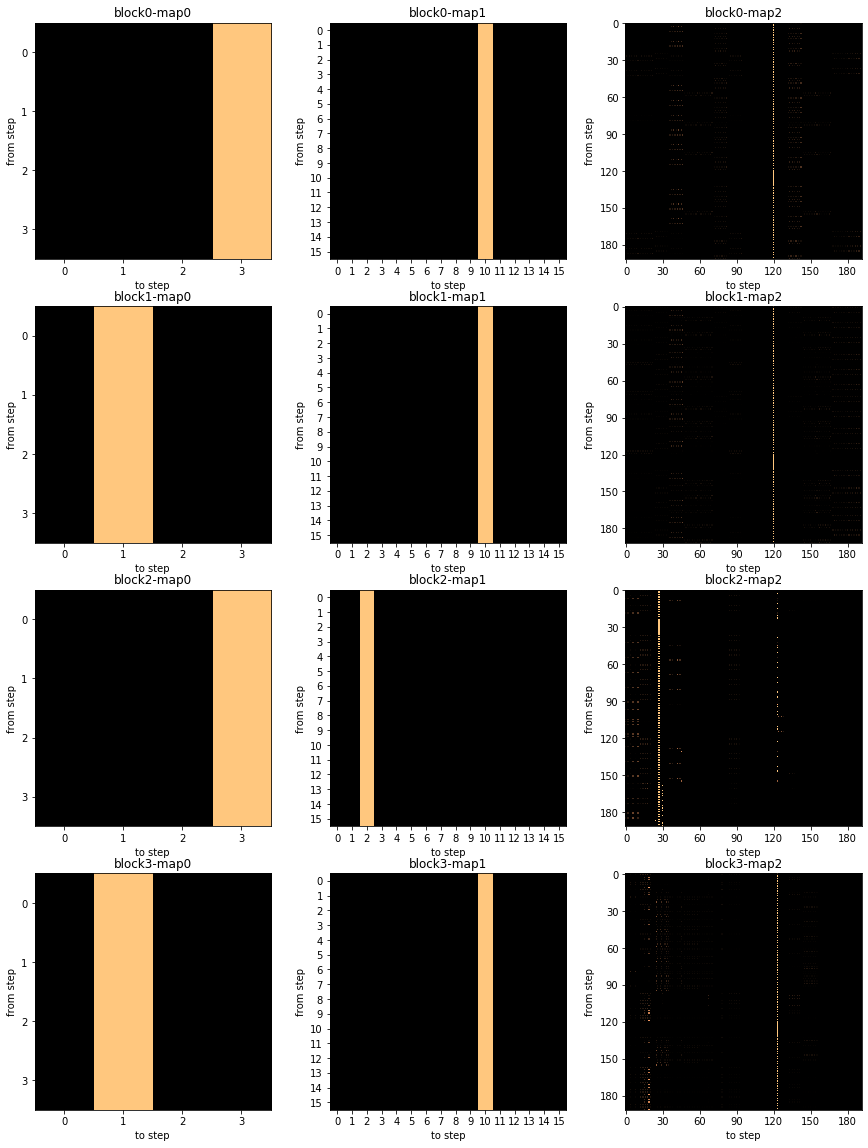

In [104]:
show_attention_maps(maps_list)

on_chord_rateのヒストグラムを表示

In [13]:
on_chord_rates = []
for i in range(1000):
    song = song_generator.generate(base, chords, generated_bars_list=generated, name=song_name)
    on_chord_rates.append(on_chord_rate(song))

(array([  0.,   0.,   0.,   0.,  32., 473., 468.,  27.,   0.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

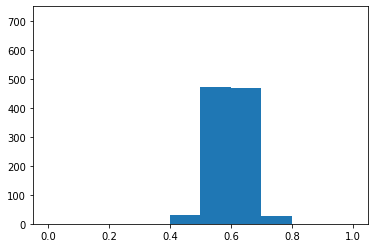

In [14]:
plt.ylim(0, 750)
plt.hist(np.array(on_chord_rates), range=(0.0, 1.0))

In [15]:
np.array(on_chord_rates).mean()

0.6006854606087259

エントロピーのヒストグラムを表示

In [11]:
def song_map_entropy(a):
    entropy = (- (a * np.log2(a+1e-10)).sum(axis=1)).mean()
    return entropy

In [12]:
entropy_list = []
for i in range(1000):
    song = song_generator.generate(base, chords, generated_bars_list=generated, name=song_name)
    song_map = song_generator.song_map
    entropy_list.append(song_map_entropy(song_map))

(array([ 11.,  44., 124., 198., 232., 178., 116.,  62.,  25.,  10.]),
 array([0.00304102, 0.00519562, 0.00735022, 0.00950482, 0.01165942,
        0.01381402, 0.01596862, 0.01812322, 0.02027782, 0.02243242,
        0.02458702], dtype=float32),
 <a list of 10 Patch objects>)

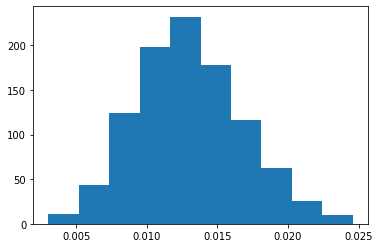

In [13]:
plt.hist(np.array(entropy_list))

In [14]:
np.array(entropy_list).mean()

0.013004618

## サンプルのオーディオ化

In [105]:
tempo = 120
song.tracks[0].program = 90
song.tracks[1].program = 0
song.tracks[0].assign_constant(100)
song.tracks[1].assign_constant(64)

print("melody instrument:", pretty_midi.program_to_instrument_name(song.tracks[0].program))
print("chord  instrument:", pretty_midi.program_to_instrument_name(song.tracks[1].program))
save_dir = os.path.join(learning_dir, version)

ppr_to_audio(song, save_dir)

melody instrument: Pad 3 (polysynth)
chord  instrument: Acoustic Grand Piano
wave file length: 1806263
wave file saved to ../datasets/theorytab/midinet/learning/midinet_long_sa/sample000_C.wav
sample000_C.midi file saved!
The wave file is replaced to ../datasets/theorytab/midinet/learning/midinet_long_sa/sample000_C.mp3 



## 生成音楽の読み込みと可視化，再生

In [7]:
from utils import grid_plot, get_sample
%matplotlib inline

version = "midinet_long_sa"
learning_dir = "../datasets/theorytab/midinet/learning"
audio, ppr = get_sample(f"{learning_dir}/{version}")

grid_plot(ppr)
audio

no sound file found in ../datasets/theorytab/midinet/learning/midinet_long


AttributeError: 'NoneType' object has no attribute 'beat_resolution'

現存の曲をいじったりもできる

In [33]:
ppr.name = "sample002_C#"
for track in ppr.tracks:
    track.transpose(1)
ppr_to_audio(ppr, save_dir)

wave file length: 926100
wave file saved to ../datasets/theorytab/midinet/learning/midinet2_dense/sample002_C#.wav
sample002_C#.midi file saved!
The wave file is replaced to ../datasets/theorytab/midinet/learning/midinet2_dense/sample002_C#.mp3 

